In [85]:
import pandas as pd
import numpy as np
import pickle
import os
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [86]:
data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/two_class_pp_5s_0.5.csv"
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

In [87]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [88]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [89]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,139.842482
11,acc_x_spectral_flatness,135.375100
78,gyr_y_spectral_spread,135.147833
95,gyr_z_spectral_spread,125.213107
98,gyr_z_hjorth_frequency,122.914314
...,...,...
23,acc_y_min,4.194527
70,gyr_y_mean,3.864838
40,acc_z_min,1.630851
53,gyr_x_mean,0.029069


### XGBoost

In [90]:
model = XGBClassifier(
    n_estimators=284,
    max_depth=9,
    learning_rate=0.03730930,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=3.6165,
    reg_alpha=1.5085,
    reg_lambda=1.29783,
)

In [91]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [92]:
model.fit(X_train_selected, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [93]:
# classes = ['non-void', 'void']

In [94]:
classes = ['non-void', 'void']
# y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
report = classification_report(y_test, y_pred, labels=[0, 1], target_names=classes)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       149
           1       0.80      0.39      0.53        94

    accuracy                           0.73       243
   macro avg       0.76      0.67      0.67       243
weighted avg       0.75      0.73      0.70       243



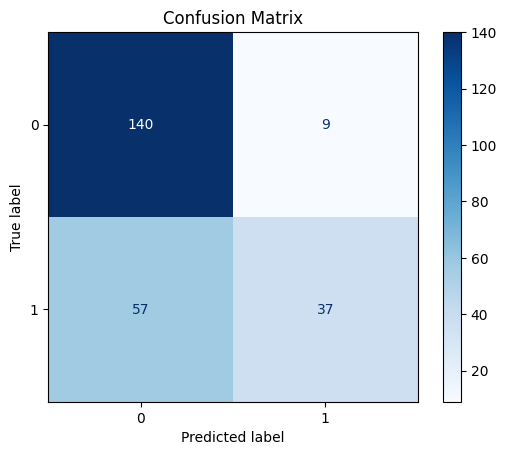

In [95]:
labels_ordered = ['void', 'non-void']
# Confusion matrix with void on top
cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()

### RandomForest

In [96]:
# select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
# selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
#                                     'Scores':select_feature.scores_})
# selected_features_df.sort_values(by='Scores', ascending=False)

In [97]:
# X_train_selected = select_feature.transform(X_train)
# X_test_selected = select_feature.transform(X_test)

In [98]:
# model = RandomForestClassifier(
#         n_estimators=311,
#         max_depth=7,
#         min_samples_split=14,
#         min_samples_leaf=8,
#         max_features='sqrt',
#         bootstrap=False,
#         class_weight='balanced',
#         random_state=42)

In [99]:
# model.fit(X_train_selected, y_train)

In [100]:
# classes = ['non-void', 'void']
# # y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
# y_pred = model.predict(X_test_selected)
# y_pred_prob = model.predict_proba(X_test_selected)
# y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
# report = classification_report(y_test, y_pred, labels=[0, 1], target_names=classes)
# report = classification_report(y_test, y_pred)

# print(report)

In [101]:
# labels_ordered = ['void', 'non-void']
# # Confusion matrix with void on top
# cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# disp.ax_.set_title('Confusion Matrix')
# plt.show()

## Overlay predictions on original plots

In [102]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
    
gender = pd.read_excel('../data/demographics_uroflowmetry.xlsx', index_col=0)
gender.drop(['Age', 'Waist Circumference (cm)', 'Height (cm)', 'Weight (Kg)', 'GD Vol (ml)', 'NOTES'], axis=1, inplace=True)
sex = gender['Gender']
sex = np.array(sex)

In [103]:
voids = {
    'subj_1_void7': 5, 
    'subj_2_void2': 9,
    'subj_2_void7': 14,
    'subj_3_void8': 20,
    'subj_5_void2': 25,
    'subj_5_void3': 26,
    'subj_8_void1': 30,
    'subj_15_void1': 40,
    'subj_16_void1': 41
}

In [104]:
# Keep everything together for easier analysis
test_results = pd.DataFrame({
    'group': groups_test,
    'actual': y_test,
    'predicted': y_pred
})

In [105]:
features_df = pd.read_csv("/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/two_class_pp_5s_0.5.csv")

In [106]:
def plot_predictions_with_timing(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    non_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 1:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        # else:  # Non-void prediction
        #     ax_pred.axvspan(start_time, end_time, alpha=0.4, color='lightblue')
        #                 # label='Non-void Prediction' if not non_void_label_added else "")
        #     non_void_label_added = True
    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred



Experiment ID: 5; Instance: subj_1_void7
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Experiment ID: 9; Instance: subj_2_void2
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 14; Instance: subj_2_void7
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Experiment ID: 20; Instance: subj_3_void8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Experiment ID: 25; Instance: subj_5_void2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 26; Instance: subj_5_void3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_26997/2584983520.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


Experiment ID: 30; Instance: subj_8_void1
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Experiment ID: 40; Instance: subj_15_void1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 41; Instance: subj_16_void1
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


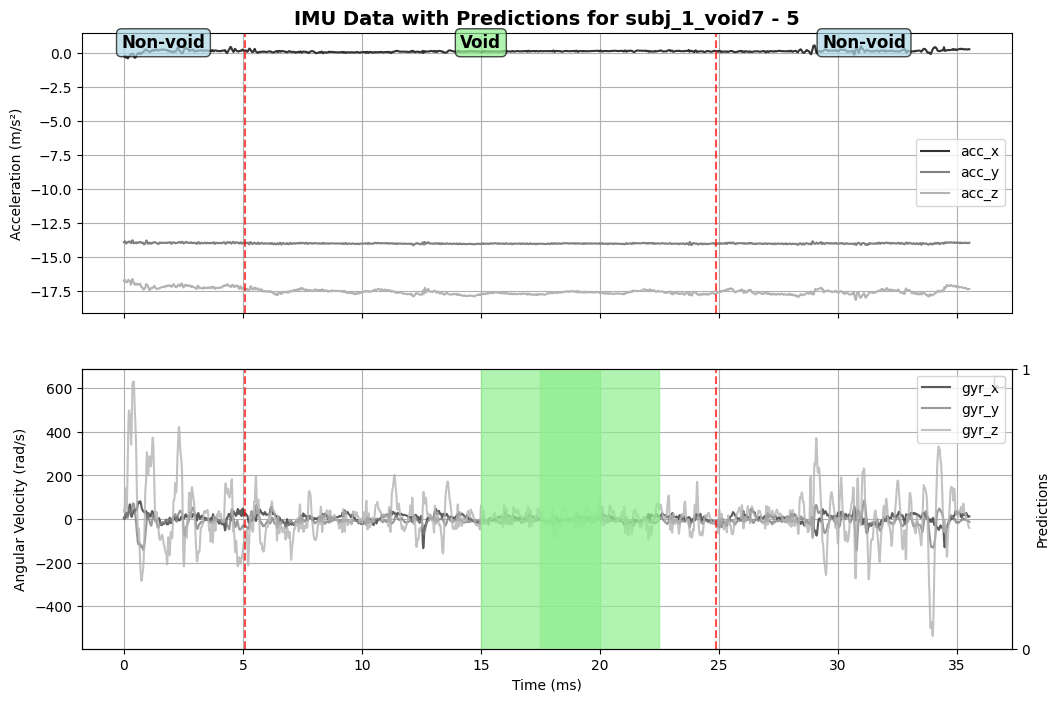

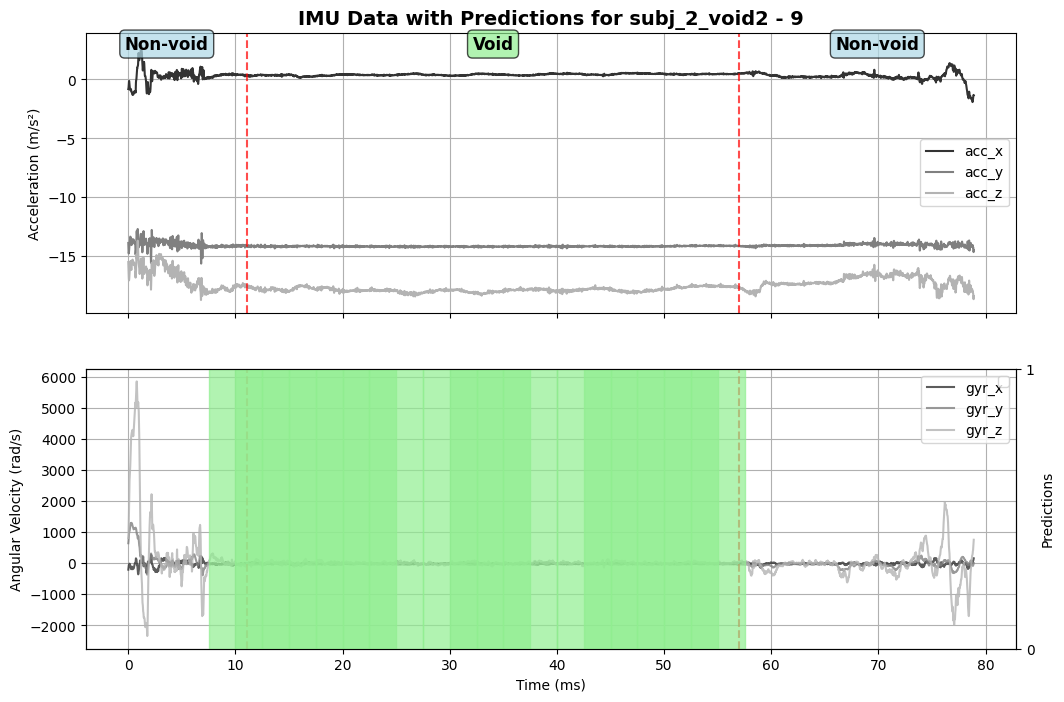

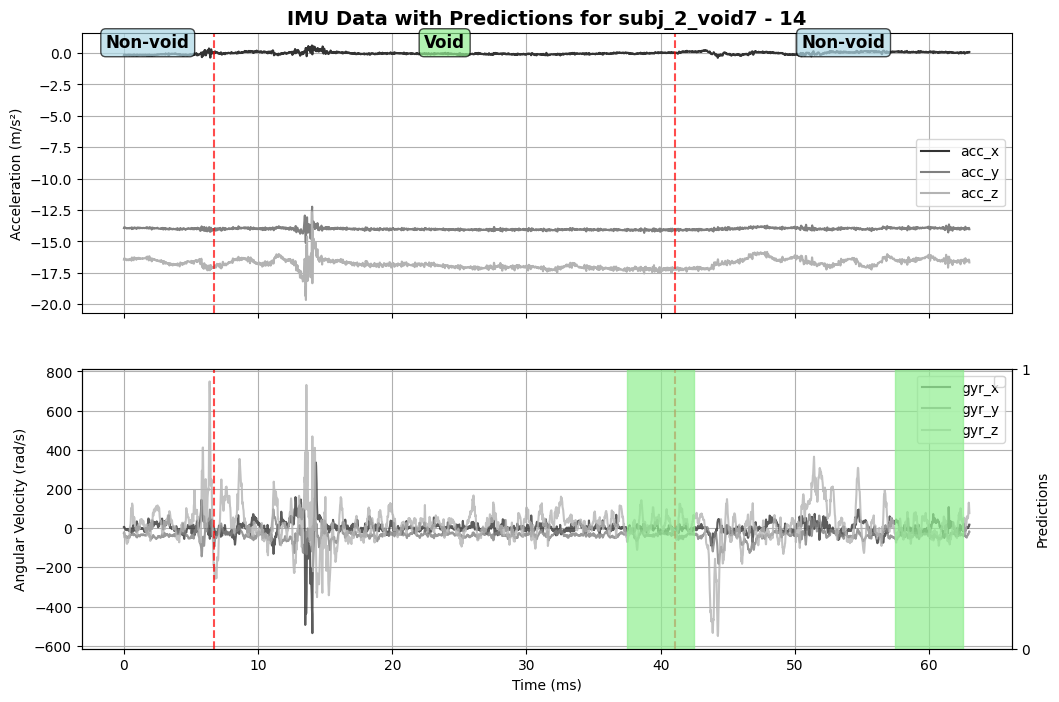

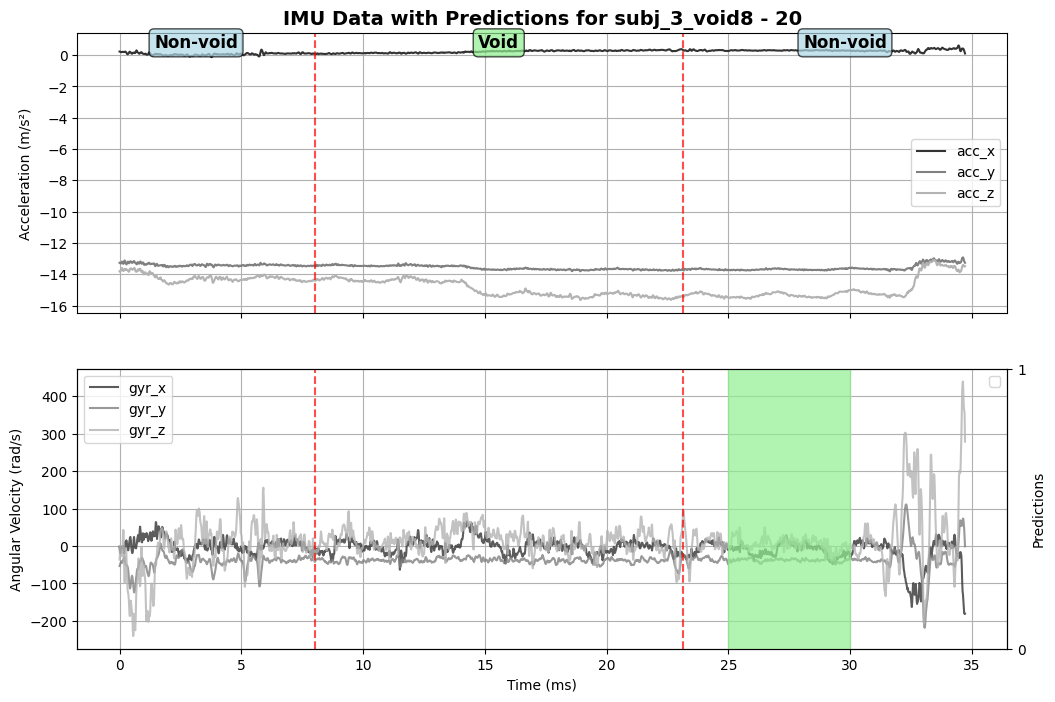

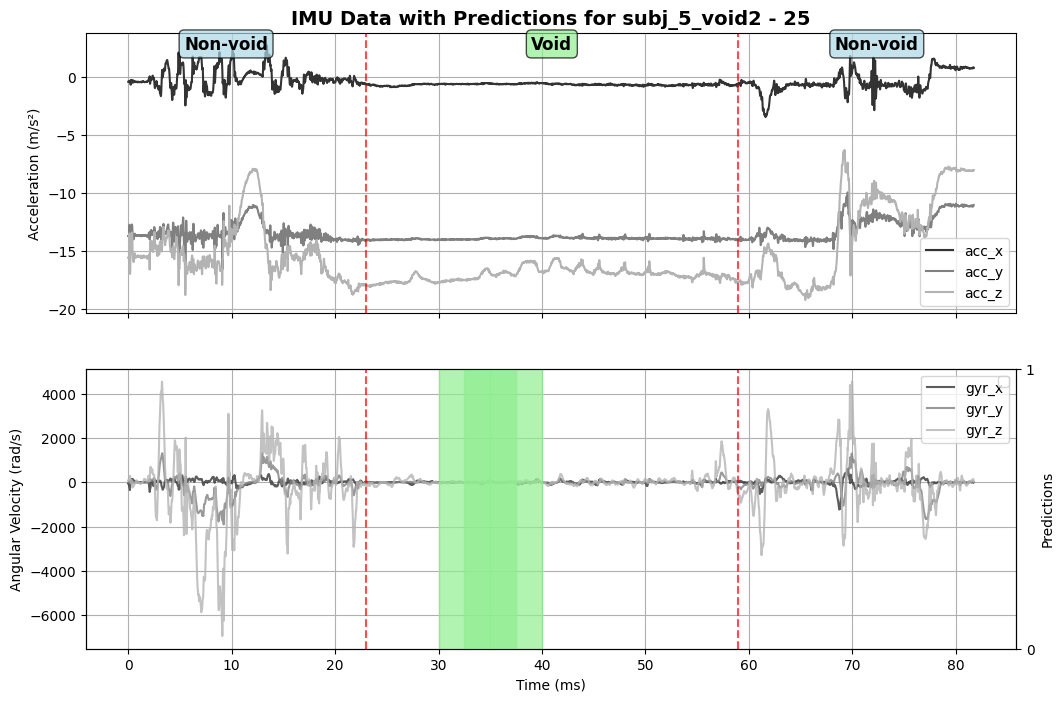

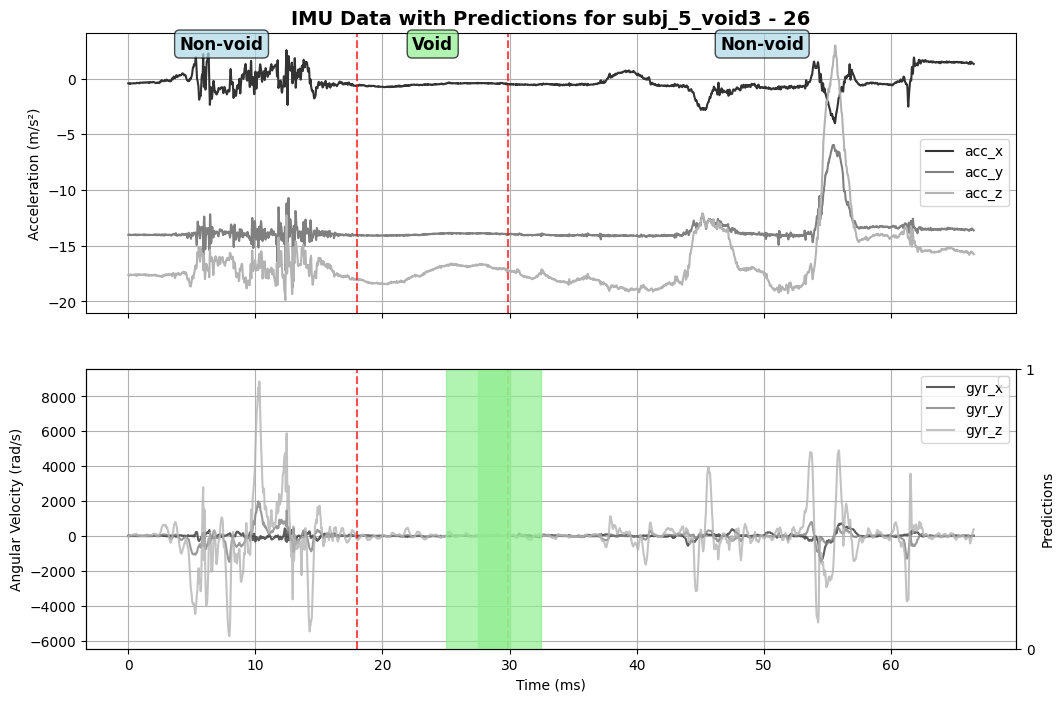

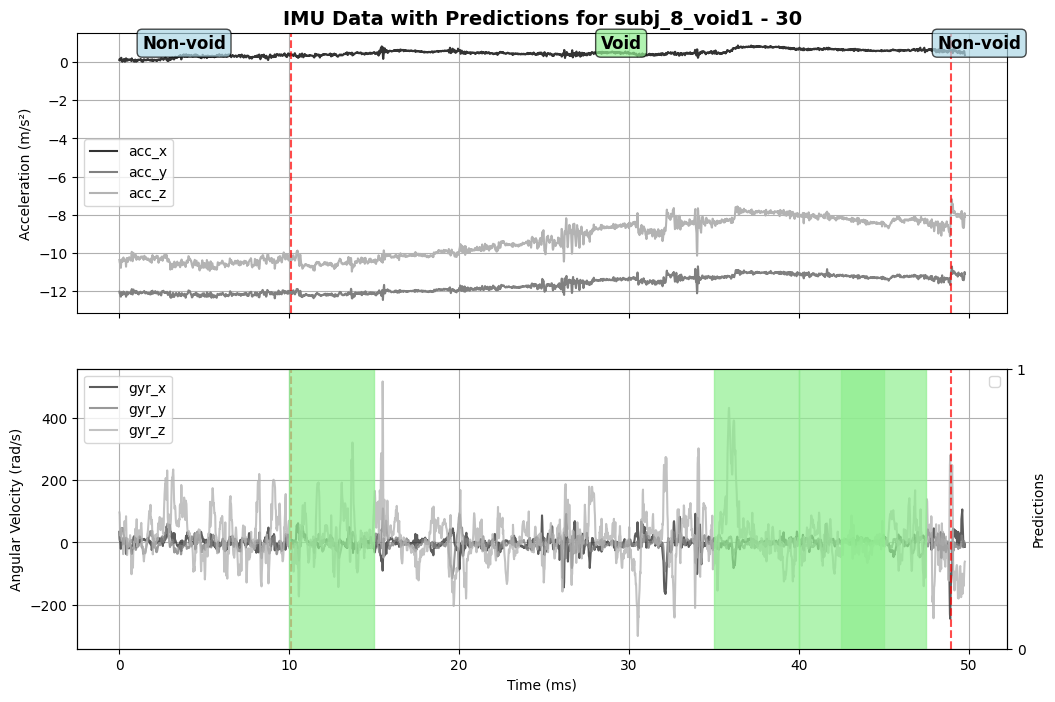

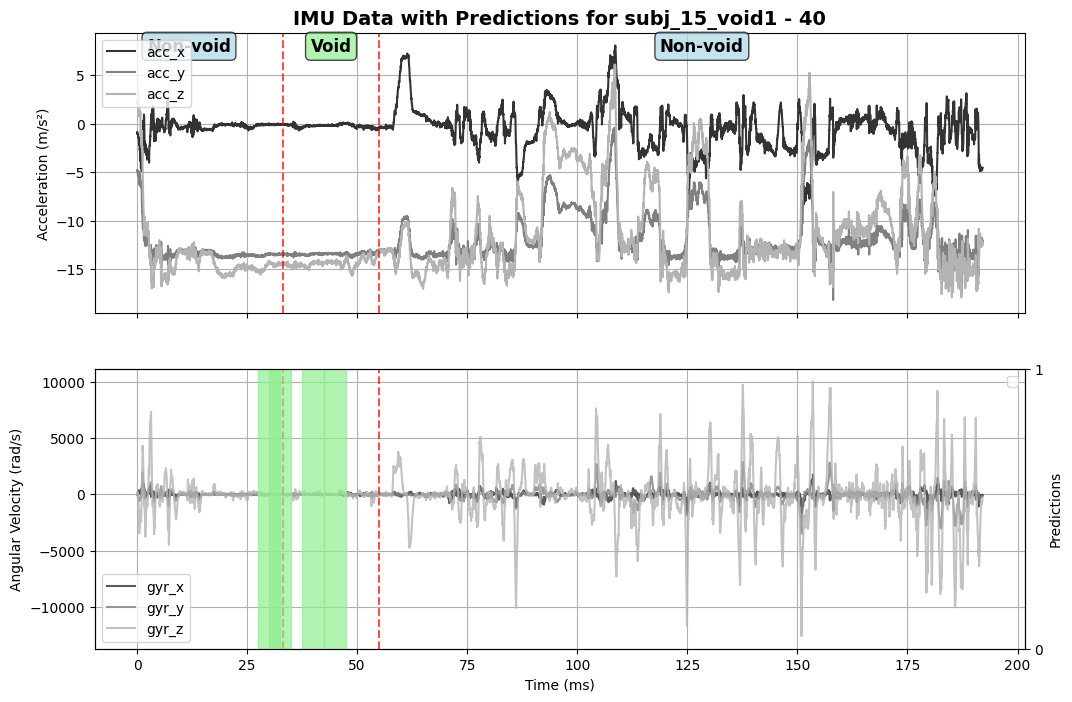

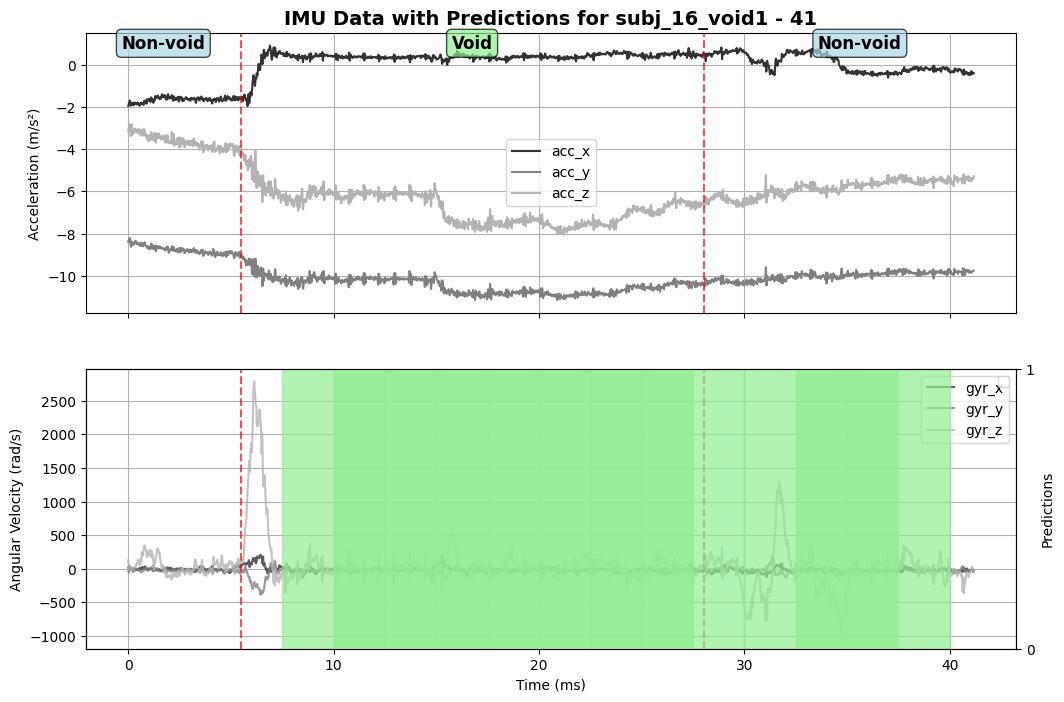

In [107]:

for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
        
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 

    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    # Add title
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
        
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)

    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()

    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Non-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Non-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
        
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)


    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results[test_results['group'] == exp_id]['predicted'].tolist()
    actual_labels = test_results[test_results['group'] == exp_id]['actual'].tolist()
    features_df_ = features_df[features_df['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing(features_df_, predicted_labels, ax_pred)


    # Add legend that combines both axes# model.fit(X_train, y_train)

    lines1, labels1 = ax_bottom.get_legend_handles_labels()
    lines2, labels2 = ax_pred.get_legend_handles_labels()
    ax_bottom.legend(lines1 + lines2, labels1 + labels2, loc='best')
        
        
    # path_5s_0_5 = 'plots'
    # # Save plot   
    # if not os.path.exists(path_5s_0_5):
    #     os.mkdir(path_5s_0_5)
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # else:
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # plt.close()

# HMM

In [108]:
y_pred_prob

array([[0.77269304, 0.22730693],
       [0.7816135 , 0.21838646],
       [0.8328879 , 0.16711213],
       [0.7307039 , 0.2692961 ],
       [0.73908454, 0.26091546],
       [0.51692015, 0.48307985],
       [0.34047782, 0.6595222 ],
       [0.40561885, 0.59438115],
       [0.716527  , 0.283473  ],
       [0.63311195, 0.36688808],
       [0.7946029 , 0.20539713],
       [0.74757296, 0.25242704],
       [0.79004586, 0.20995417],
       [0.92586935, 0.07413067],
       [0.8504852 , 0.14951482],
       [0.83202565, 0.16797434],
       [0.489039  , 0.510961  ],
       [0.4159184 , 0.5840816 ],
       [0.44790602, 0.552094  ],
       [0.45271176, 0.54728824],
       [0.4270016 , 0.5729984 ],
       [0.1962443 , 0.8037557 ],
       [0.3740136 , 0.6259864 ],
       [0.557289  , 0.44271097],
       [0.47474706, 0.52525294],
       [0.35579628, 0.6442037 ],
       [0.26113945, 0.73886055],
       [0.47915447, 0.52084553],
       [0.6474837 , 0.35251626],
       [0.3475206 , 0.6524794 ],
       [0.

In [109]:
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=classes)
y_pred_prob_df['experiment_id'] = groups_test.values

In [110]:
void_probs_exp_ids = y_pred_prob_df.drop(columns=['non-void'])
void_probs_exp_ids

,void,experiment_id
0,0.227307,5
1,0.218386,5
2,0.167112,5
3,0.269296,5
4,0.260915,5
...,...,...
238,0.771966,41
239,0.463372,41
240,0.520841,41
241,0.525950,41


In [147]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

def implementation_2_best_seed(df, prob_col='void', id_col='experiment_id', n_states=3, seeds=range(200)):
    # transmat = np.array([
    #     [0.7, 0.3, 0.0],    # pre-void -> mostly stay, can go to void
    #     [0.0, 0.90, 0.1],   # void -> mostly stay, can go to post-void
    #     [0.0, 0.0, 1.0]     # post-void -> terminal
    # ])
    
    
    transmat = np.array([
    [0.85, 0.15, 0.0],   # pre-void: mostly stay, can go to void
    [0.0, 0.80, 0.20],   # void: mostly stay, can go to post-void
    [0.0, 0.0, 1.0]    # post-void: mostly stay, can cycle back to pre-void
])
    
    startprob = np.array([1.0, 0.0, 0.0])
    
    # Prepare combined observations once
    all_obs = []
    lengths = []
    for exp_id, group in df.groupby(id_col):  # Fixed: was id*col
        observations = (group[prob_col] >= 0.20).astype(int).to_numpy().reshape(-1, 1)
        all_obs.append(observations)
        lengths.append(len(observations))
    all_obs = np.vstack(all_obs)
    
    best_score = -np.inf
    best_model = None
    best_seed = None  # Initialize to avoid UnboundLocalError
    
    # Try multiple seeds and keep the best
    for seed in seeds:
        try:
            model = hmm.CategoricalHMM(
                n_components=n_states,
                init_params="e",  # only emissions will be learned
                n_iter=100,
                tol=1e-4,
                random_state=seed
            )
            model.startprob_ = startprob
            model.transmat_ = transmat
            model.fit(all_obs, lengths)
            score = model.score(all_obs, lengths)
            
            if score > best_score:
                best_score = score
                best_model = model
                best_seed = seed
                
        except Exception as e:
            print(f"Seed {seed} failed: {e}")
            continue
    
    if best_model is None:
        raise ValueError("All seeds failed to converge!")
    
    # Decode using the best model
    state_map = {0: 'pre-void', 1: 'void', 2: 'post-void'}
    all_results = []
    
    for exp_id, group in df.groupby(id_col):
        observations = (group[prob_col] >= 0.20).astype(int).to_numpy().reshape(-1, 1)
        _, hidden_states = best_model.decode(observations, algorithm="viterbi")  # Fixed: was *, hidden*states
        
        group_result = group.copy()
        group_result['predicted_state'] = [state_map[s] for s in hidden_states]
        all_results.append(group_result)
    
    return pd.concat(all_results), best_model.emissionprob_, best_score, best_seed

In [148]:
best_test_state_preds, best_emissionprob, best_score, best_seed = implementation_2_best_seed(void_probs_exp_ids, n_states=3, seeds=range(200))
state_preds = best_test_state_preds['predicted_state'].values

In [149]:
state_preds

array(['pre-void', 'pre-void', 'pre-void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'void', 'pre-void',
       'pre-void', 'pre-void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'post-void', 'post-void', 'post-void', 'post-void',
       'pre-void', 'pre-void', 'pre-void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'void', 'void', 'void',
       'void', 'post-void', 'post-void', 'post-void', 'post-void',
       'post-void', 'post-void', 'post-void', 'post-void', 'pre-void',
       'pre-void', 'pre-void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'pre-void', 'pre-void', 'pre-void',
       'pre-void', 'pre-void', 'pre-void', 'pre-void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'void', 'void', 'void'

In [150]:
state_pred_enc = label_encoder.fit_transform(state_preds)

In [151]:
state_pred_enc

array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [152]:
state_pred_enc = state_pred_enc.tolist()

In [153]:
test_results['hmm_pred'] = state_pred_enc

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,def optimize_model(self, model_name: str, X_train, y_train, groups_train) -> Tuple[Dict, float]:
        """Optimize hyperparameters for a specific model using inner CV."""
        
        def objective(trial):
            params = self.get_model_search_space(model_name, trial)
            fold_scores = []

            for train_idx, val_idx in self.inner_cv.split(X_train, y_train, groups_train):
                try:
                    X_train_inner = X_train.iloc[train_idx]
                    X_val_inner = X_train.iloc[val_idx]
                    y_train_inner = y_train[train_idx]
                    y_val_inner = y_train[val_idx]

                    model = self.create_model(model_name, params)
                    model.fit(X_train_inner, y_train_inner)

                    # Get predicted probabilities for the validation set
                    y_proba = model.predict_proba(X_val_inner)

                    # Calculate negative log loss (maximize this = minimize log loss)
                    score = -log_loss(y_val_inner, y_proba)
                    fold_scores.append(score)
                    
                except Exception as e:
                    print(f"Warning: Error in inner fold for {model_name}: {e}")
                    # Use Optuna's pruning mechanism instead of arbitrary score
                    raise optuna.TrialPruned()

            return np.mean(fold_scores) if fold_scores else -np.inf
                       'display.precision', 3,
                       ):
    print(test_results)





     group  actual  predicted  hmm_pred
76       5       0          0         1
77       5       0          0         1
78       5       1          0         1
79       5       1          0         2
80       5       1          0         2
81       5       1          0         2
82       5       1          1         2
83       5       1          1         2
84       5       1          0         2
85       5       0          0         2
86       5       0          0         2
87       5       0          0         2
88       5       0          0         2
150      9       0          0         1
151      9       0          0         1
152      9       0          0         1
153      9       0          1         2
154      9       1          1         2
155      9       1          1         2
156      9       1          1         2
157      9       1          1         2
158      9       1          1         2
159      9       1          1         2
160      9       1          0         2


In [155]:
def plot_predictions_with_timing(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    post_void_label_added = False
    pre_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 2:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        # elif prediction == 0:  # Post void prediction
        #     ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightcoral')
        #     post_void_label_added = True
        # elif prediction == 1:  # Pre void prediction
        #     ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightblue')
        #     pre_void_label_added = True

    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred

Experiment ID: 5; Instance: subj_1_void7
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Experiment ID: 9; Instance: subj_2_void2
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Experiment ID: 14; Instance: subj_2_void7
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 20; Instance: subj_3_void8
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Experiment ID: 25; Instance: subj_5_void2
[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 26; Instance: subj_5_void3
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 30; Instance: subj_8_void1
[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


/tmp/ipykernel_26997/3412657704.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


Experiment ID: 40; Instance: subj_15_void1
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 41; Instance: subj_16_void1
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


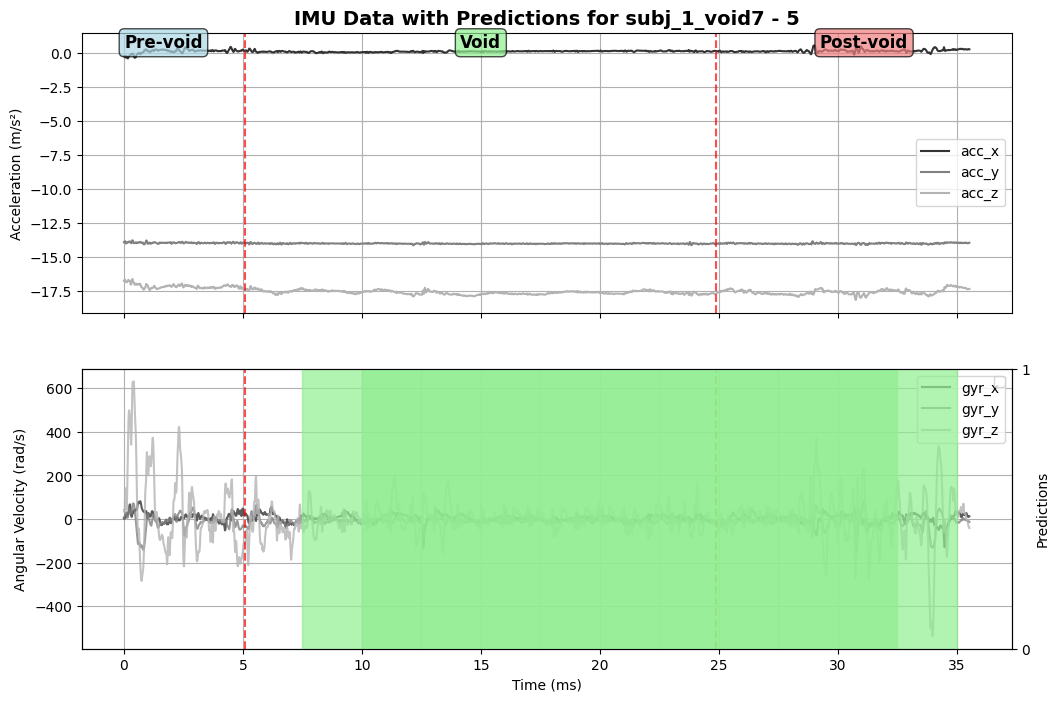

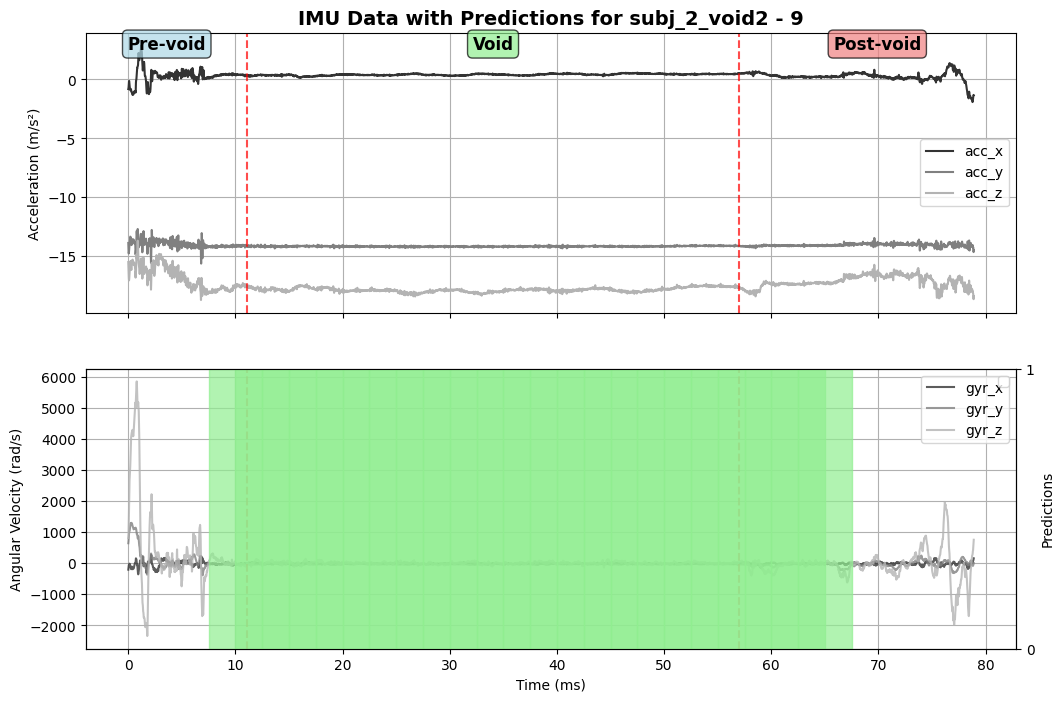

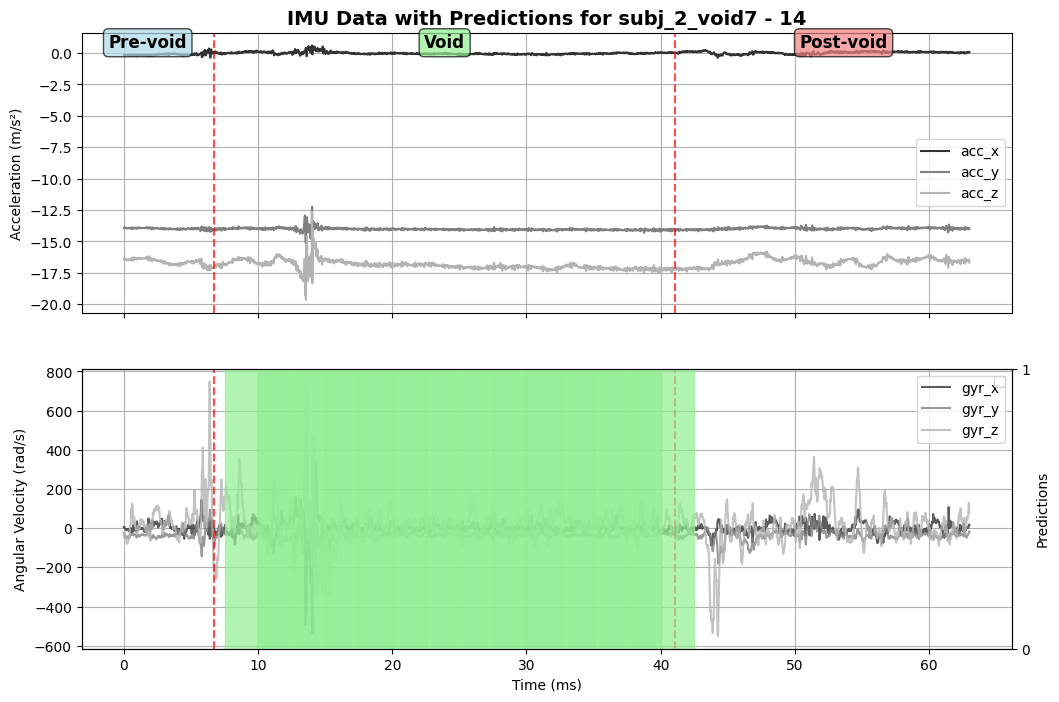

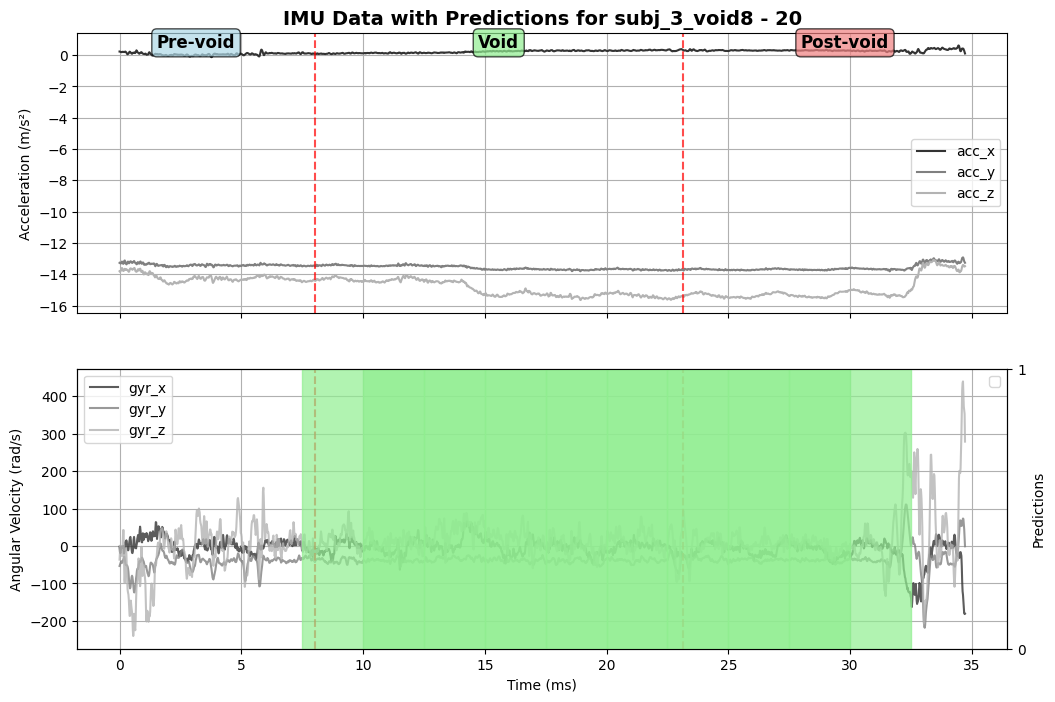

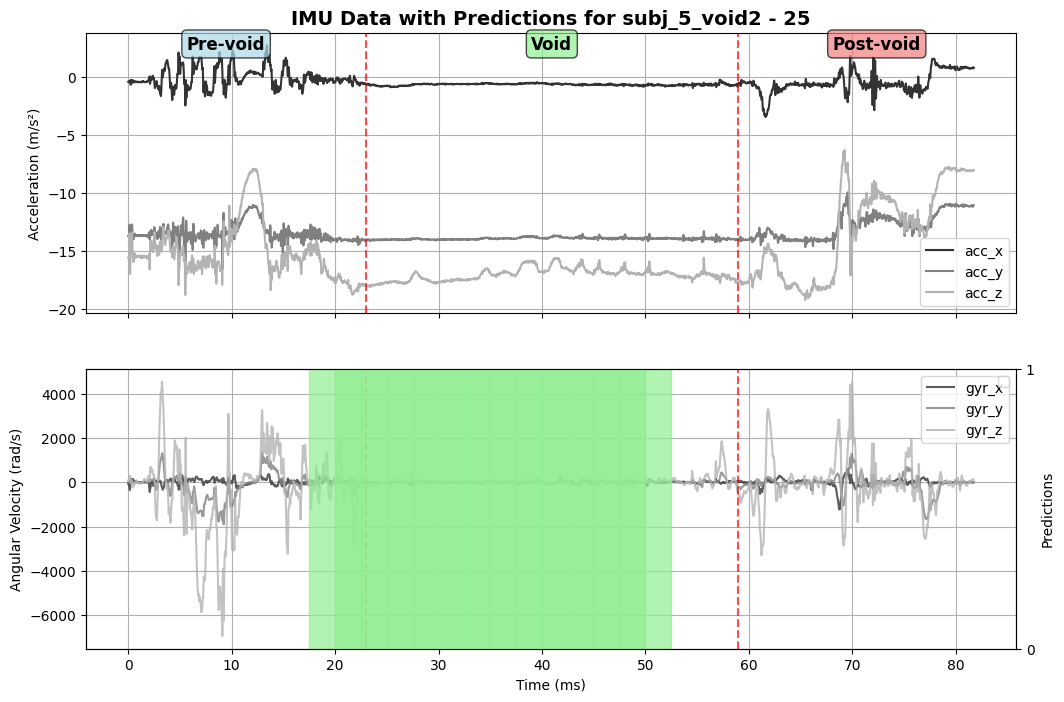

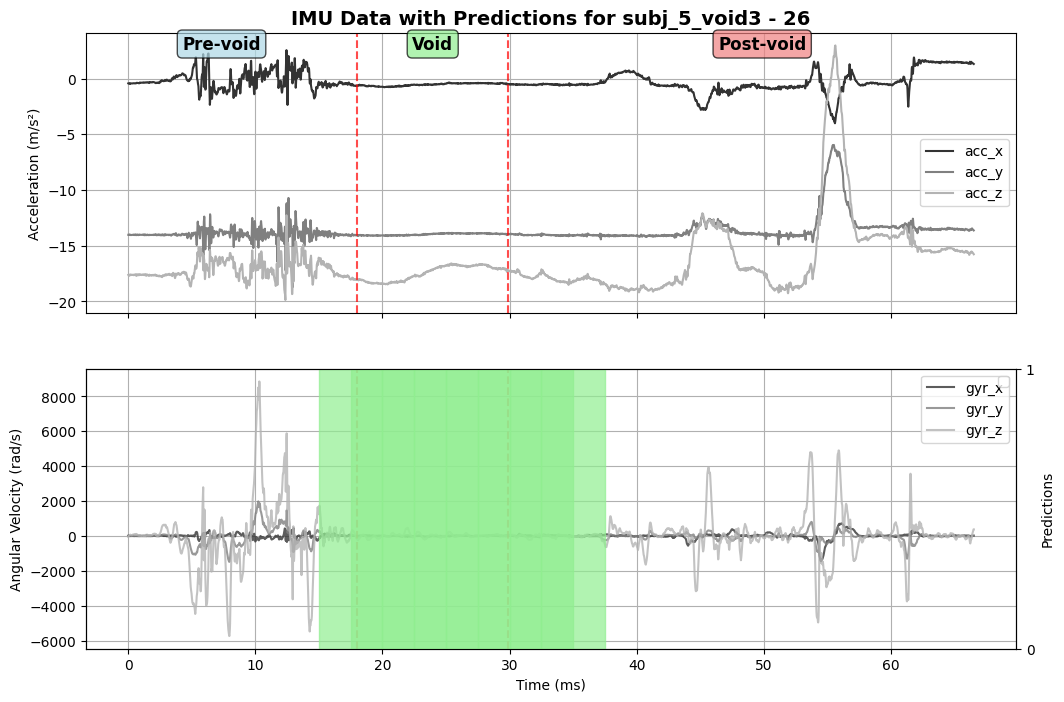

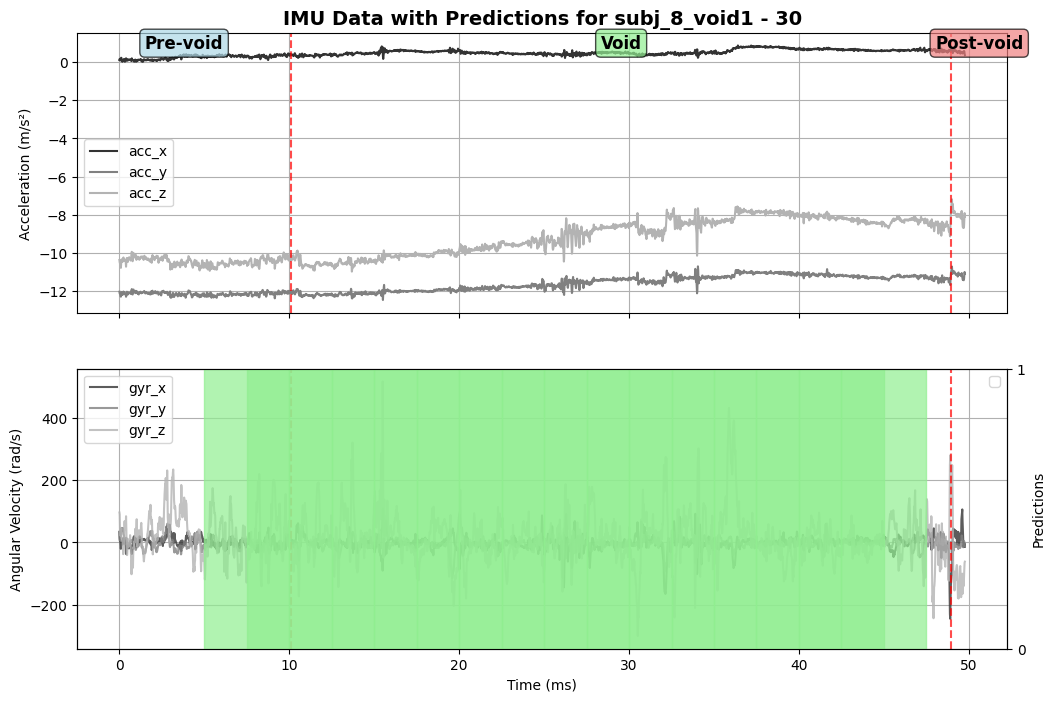

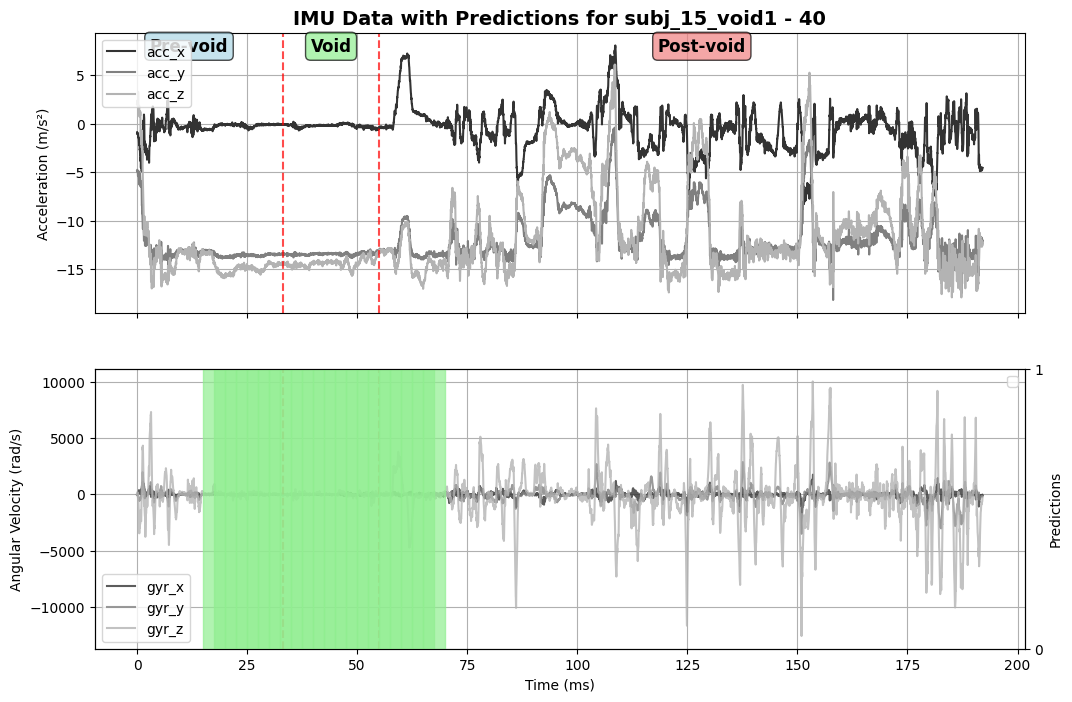

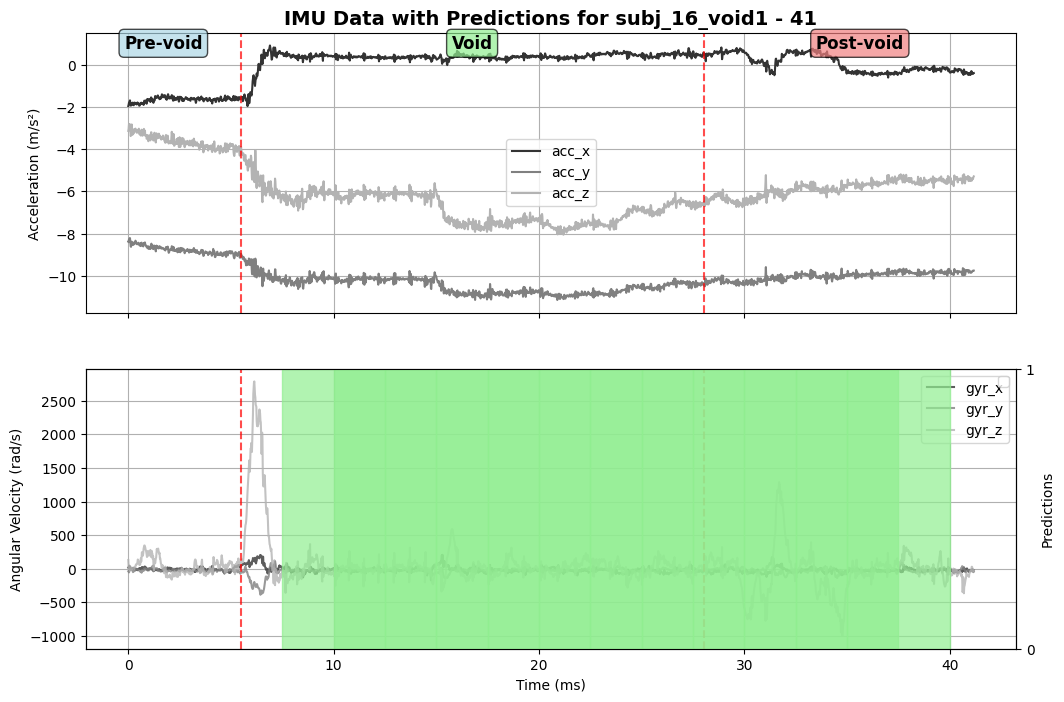

In [156]:
for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
    
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 
    
    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
    
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
    
    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()
    
    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Pre-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
    
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Post-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
    
    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results[test_results['group'] == exp_id]['hmm_pred'].tolist()
    actual_labels = test_results[test_results['group'] == exp_id]['actual'].tolist()
    features_df_ = features_df[features_df['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing(features_df_, predicted_labels, ax_pred)
    
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
    
    # # Save plot   
    # if not os.path.exists(acc_gyr_path):
    #     os.mkdir(acc_gyr_path)
    #     filename = os.path.join(acc_gyr_path, f'{void_instance}_acc_gyr.png')
    #     plt.savefig(filename)
    # else:
    #     filename = os.path.join(acc_gyr_path, f'{void_instance}_acc_gyr.png')
    #     plt.savefig(filename)
    # plt.close()
    
    
    # path_5s_0_5 = 'plots'
    # # Save plot   
    # if not os.path.exists(path_5s_0_5):
    #     os.mkdir(path_5s_0_5)
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # else:
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # plt.close()

In [157]:
# # Method 2: If windows are consecutive with known step size
# def reconstruct_with_step(predictions, window_size, step_size, start_time=0):
#     """
#     Reconstruct when you know the step size between windows
#     """
#     timeline_positions = []
#     timeline_predictions = []
    
#     for i, pred in enumerate(predictions):
#         # Calculate the center time of this window
#         window_start = start_time + (i * step_size)
#         window_center = window_start + (window_size // 2)
        
#         timeline_positions.append(window_center)
#         timeline_predictions.append(pred)
    
#     return pd.DataFrame({
#         'time_position': timeline_positions,
#         'prediction': timeline_predictions
#     })

In [122]:
# import matplotlib.pyplot as plt

# # Reconstruct your timeline
# timeline_df = reconstruct_with_step(predicted_labels, window_size=5, step_size=0.5)

# # Plot like your diagram
# plt.figure(figsize=(12, 4))

# # Plot the predictions as a timeline
# plt.step(timeline_df['time_position'], timeline_df['prediction'], 
#         where='mid', linewidth=2, label='Predicted Labels')


# plt.xlabel('Time')
# plt.ylabel('Predicted Label')
# plt.title('Timeline Reconstruction from Sliding Window Predictions')
# plt.legend()
# plt.show()

In [123]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print()

In [124]:
arr = [2,3,7,4,1,10]

x = 0
for i in arr:
    if i >= x:
        x = i
x

10

In [125]:
x = arr[0]
for i in arr:
    if i <= x:
        x = i
x

1

In [158]:
three_preds = [0,1,0,0,1,2,2,2,2,2,0,1,1,1,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,2,0,0,0,1,0,0,0,2,0,0,0,0,2,2,2,2,0,1,2,0,1,0,0,0,0,0,0,0,1,0,0,2,2,2,2,2,0,0,2,2,0,0,1,1,1,0,1,1,0,1,1,1,0,0,1,0,0,0,2,2,2,2,2,2,2,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,2,2,0,2,2,2,2,2,2,0,2,2,2,2,1,1,1,0,0,0,2,2,0,1,1,2,2,2,1,2,2,2,2,2,0,0,0,1,2,1,1,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2]
hmm_preds = test_results['hmm_pred']

In [159]:
print(len(three_preds))
print(len(hmm_preds))

243
243


In [160]:
report = classification_report(three_preds, hmm_preds)
report = classification_report(three_preds, hmm_preds)

print(report)

              precision    recall  f1-score   support

           0       0.37      0.34      0.35        88
           1       0.22      0.11      0.15        70
           2       0.67      0.99      0.80        85

    accuracy                           0.50       243
   macro avg       0.42      0.48      0.43       243
weighted avg       0.43      0.50      0.45       243



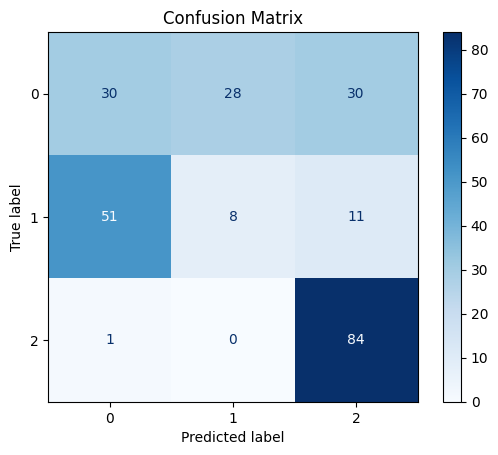

In [161]:
labels_ordered = ['void', 'non-void']
# Confusion matrix with void on top
cm = confusion_matrix(three_preds, hmm_preds)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()